**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score



# Data Preparation

In [3]:
df = pd.read_csv('scaled_datatrainingcopy.csv')
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Week_day,Occupancy
0,2.518470,0.278526,1.573763,0.364948,1.091757,1,1
1,2.488967,0.277713,1.591735,0.341881,1.080555,1,1
2,2.488967,0.273645,1.573763,0.340290,1.075889,1,1
3,2.488967,0.265508,1.573763,0.323587,1.066555,1,1
4,2.439796,0.265508,1.573763,0.311655,1.049523,1,1


## Dividing the training data

In [6]:
class_name = "Occupancy"

attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [7]:
df[class_name].value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

In [8]:
rows2remove = np.random.choice(df[df[class_name] == 1].index, 483 - 50, replace=False)

In [9]:
len(df), len(rows2remove)

(8143, 433)

In [10]:
df2 = df.drop(index=rows2remove, axis=0)
print(len(df2))

7710


In [11]:
print('Dataset shape %s' % Counter(df2[class_name]))

Dataset shape Counter({0: 6414, 1: 1296})


# Data Partitioning

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [12]:
attributes = [col for col in df.columns if col != class_name]
X = df2[attributes].values
y = df2[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [13]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([4490,  907])), (array([0, 1]), array([1924,  389])))

# Classification

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.993514915693904
F1-score [0.99610693 0.98059508]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1924
           1       0.99      0.97      0.98       389

    accuracy                           0.99      2313
   macro avg       0.99      0.99      0.99      2313
weighted avg       0.99      0.99      0.99      2313



# ROC curve

In [16]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [17]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

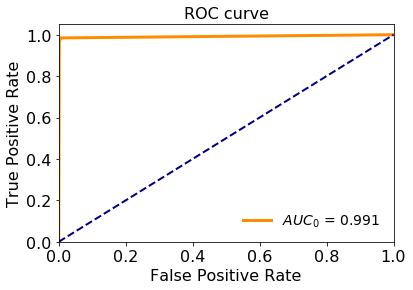

In [18]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Adjust the Decision Threshold

Accuracy 0.9922178988326849
F1-score [0.99533679 0.97650131]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1924
           1       0.99      0.96      0.98       389

    accuracy                           0.99      2313
   macro avg       0.99      0.98      0.99      2313
weighted avg       0.99      0.99      0.99      2313



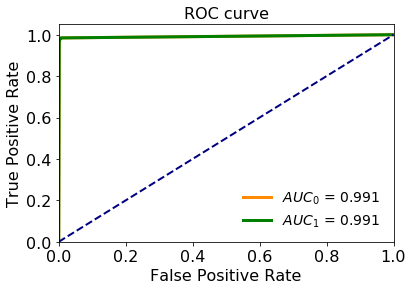

In [19]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

def adjusted_predict(X, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.8)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# PCA

In [20]:
from sklearn.decomposition import PCA

In [21]:
X_train.shape

(5397, 6)

In [22]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [23]:
X_pca.shape

(5397, 2)

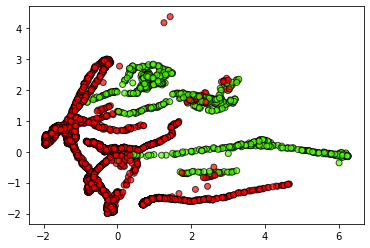

In [24]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# Undersampling

In [26]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

### RandomUnderSampler

In [27]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 907, 1: 907})


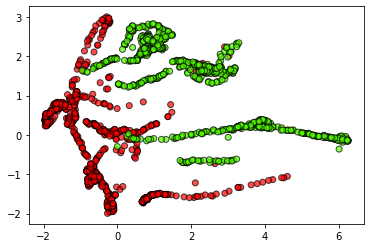

In [28]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9930825767401643
F1-score [0.99583116 0.97969543]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1924
           1       0.97      0.99      0.98       389

    accuracy                           0.99      2313
   macro avg       0.98      0.99      0.99      2313
weighted avg       0.99      0.99      0.99      2313



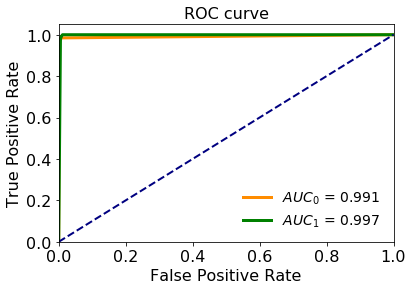

In [29]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### CondensedNearestNeighbour

In [30]:
import warnings
warnings.simplefilter("ignore")

In [31]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 907, 0: 42})


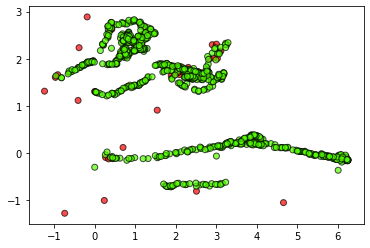

In [32]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9948119325551232
F1-score [0.99688635 0.98445596]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       0.99      0.98      0.98       389

    accuracy                           0.99      2313
   macro avg       0.99      0.99      0.99      2313
weighted avg       0.99      0.99      0.99      2313



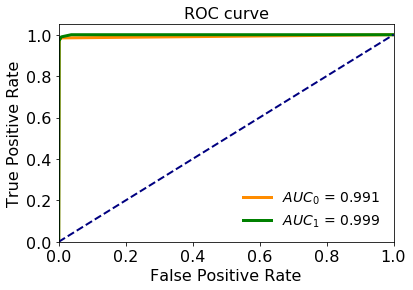

In [33]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Oversampling

In [34]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### RandomOverSampler

In [35]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4490, 1: 4490})


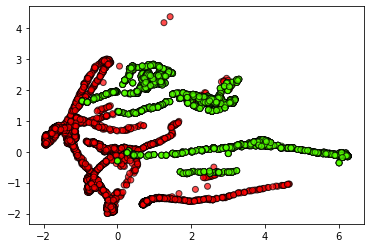

In [36]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9930825767401643
F1-score [0.99583767 0.97953964]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1924
           1       0.97      0.98      0.98       389

    accuracy                           0.99      2313
   macro avg       0.99      0.99      0.99      2313
weighted avg       0.99      0.99      0.99      2313



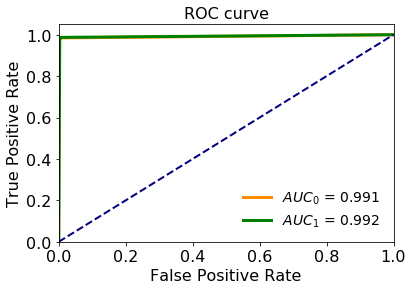

In [37]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### SMOTE

In [38]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 4490, 1: 4490})


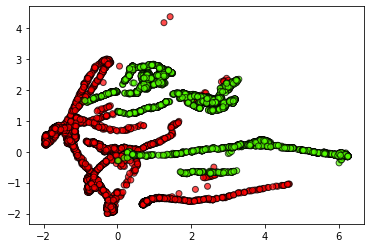

In [39]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9909208819714657
F1-score [0.99452697 0.97338403]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1924
           1       0.96      0.99      0.97       389

    accuracy                           0.99      2313
   macro avg       0.98      0.99      0.98      2313
weighted avg       0.99      0.99      0.99      2313



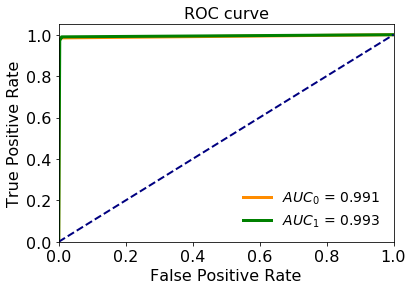

In [40]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Class Weight 

Accuracy 0.9909208819714657
F1-score [0.99453267 0.97324841]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1924
           1       0.96      0.98      0.97       389

    accuracy                           0.99      2313
   macro avg       0.98      0.99      0.98      2313
weighted avg       0.99      0.99      0.99      2313



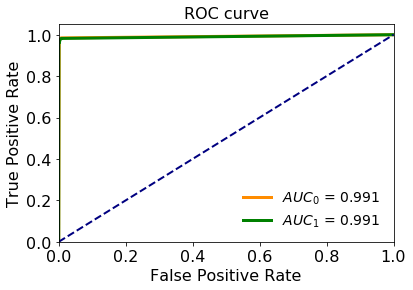

In [41]:
clf = DecisionTreeClassifier(min_samples_leaf=3, class_weight={0:1, 1: 5}, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Meta-Cost Sensitive Classifier

In [ ]:
from sklearn import cross_decomposition

In [44]:
from sklearn.cross_validation import train_test_split

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [43]:
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score

ModuleNotFoundError: No module named 'sklearn.cross_validation'

cost_mat : array-like of shape = [n_samples, 4]

Cost matrix of the classification problem Where the columns represents the costs of: false positives, false negatives, true positives and true negatives, for each example.

In [55]:
cost = [1, 10, 0, 0]
cost_mat = np.array([cost] * len(X_train))
cost_mat.shape

(2333, 4)

In [56]:
cost_mat

array([[ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       ...,
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0]])

Accuracy 0.426
F1-score [0.51273345 0.30170316]
              precision    recall  f1-score   support

           0       0.93      0.35      0.51       855
           1       0.18      0.86      0.30       145

    accuracy                           0.43      1000
   macro avg       0.56      0.60      0.41      1000
weighted avg       0.83      0.43      0.48      1000



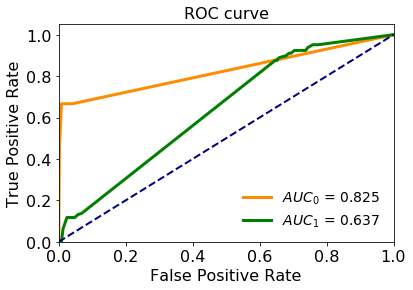

In [57]:
clf = CostSensitiveDecisionTreeClassifier()
clf.fit(X_train, y_train, cost_mat)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [58]:
cost_mat_test = np.array([cost] * len(X_test))
print(savings_score(y_test, y_pred, cost_mat_test))
print(savings_score(y_test, y_pred0, cost_mat_test))

0.10760233918128659


ValueError: operands could not be broadcast together with shapes (870,) (1000,) 

# Scikit-plot

In [45]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [46]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9909946786737618
F1-score [0.99430347 0.97851562]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.97      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.98      0.99      2443
weighted avg       0.99      0.99      0.99      2443



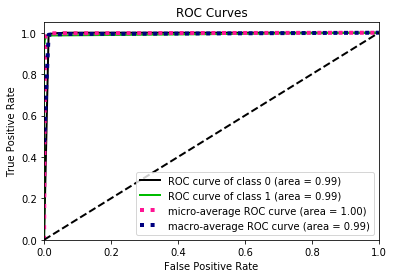

In [47]:
plot_roc(y_test, y_score)
plt.show()

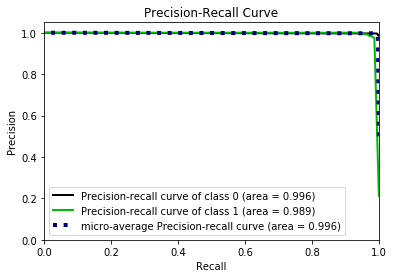

In [48]:
plot_precision_recall(y_test, y_score)
plt.show()

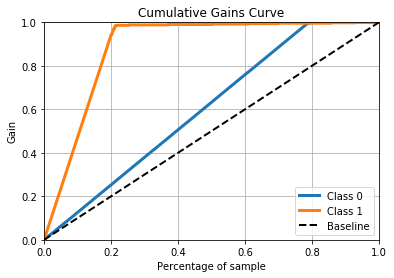

In [49]:
plot_cumulative_gain(y_test, y_score)
plt.show()

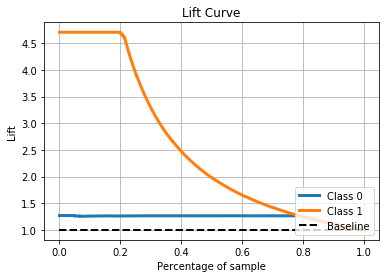

In [50]:
plot_lift_curve(y_test, y_score)
plt.show()